# Genre Classification From Lyrics.com
# Data Cleaning

In [1]:
import sqlalchemy
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import text, select
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import log

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The lyrics.com database is a collection of user-submitted lyric data comprising roughly 1.5 million submissions of song lyrics across a variety of musical genres. This dataset is derived from webscraping the full catalog of lyrics.com and storing the results in a SQLite database. 

There data is split into four relational tables:
1. artists
   - includes data related to artist info such as artist name
2. lyrics
   - includes lyrics as text data as well as song titles and listed publication year
3. genres
   - includes data classifying songs into one or more genres
4. styles
   - includes a subgenre classification of style

In [2]:
from sqlalchemy import create_engine, Table, Column
from sqlalchemy import Integer, String, Text, MetaData

engine = create_engine('sqlite:///../data/raw/lyrics.db', echo=False)

meta = MetaData()

artists = Table('artists', meta,
                Column('artist', String, primary_key=True),
                Column('artist_url', String))

lyrics = Table('lyrics', meta,
               Column('artist', String),
               Column('song_title', String),
               Column('year', Integer),
               Column('song_url', String, primary_key=True),
               Column('lyrics', Text))

genres = Table('genre', meta,
               Column('id', Integer, primary_key=True, autoincrement=True),
               Column('song_url', String),
               Column('genre', String))

styles = Table('style', meta,
               Column('id', Integer, primary_key=True, autoincrement=True),
               Column('song_url', String),
               Column('style', String))

if __name__ == '__main__':
    meta.create_all(engine)


We can set up a schema to access these tables using SQLAlchemy, which is a versatile interface for interacting with databases of all sizes in Python. Here we define each table and the rules for interaction with each of them.

In [3]:
conn = engine.connect()

In [4]:
query = text('SELECT * FROM lyrics')
artists = conn.execute(query).fetchall()
data = pd.DataFrame(artists)
data.columns = ['artist', 'song', 'year', 'url', 'lyric']
data_url = data.copy()
data = data.drop(labels='url', axis=1)

Since the dataset is mostly text information, it is able to fit into memory without a great deal of difficulty. We recast the data as a pandas dataframe.

In [5]:
num_rows = data.shape[0]
no_lyr = data.lyric.isna()

print('''
Number of rows:\t\t%s
Number of lyrics:\t%s
''' % (num_rows, no_lyr.sum()))


Number of rows:		1250843
Number of lyrics:	382600



From the lyrics dataframe we can see that we have roughly 1.25 million individual songs to work with, and that 380,000 are lacking lyric data. These tracks are largely instrumental or electronic tracks that feature no lyrical content

# Genre Tagging Completeness

In [6]:
query = """SELECT l.artist, l.song_title, l.year, g.genre, l.lyrics
           FROM lyrics l JOIN genre g ON g.song_url = l.song_url"""
genres = conn.execute(query).fetchall()
genres = pd.DataFrame(genres)
genres.columns = ['artist', 'song_title', 'year', 'genre', 'lyrics']
print('Genre tagged songs missing lyrics: %s' % (genres.lyrics.isnull().sum()))

Genre tagged songs missing lyrics: 0


Interestingly none of the songs tagged with genre information in the database are missing lyric information.

In [7]:
unique_songs = genres.groupby(['artist','song_title'])
unique_songs.count().shape

(134673, 3)

We can see that looking at unique song titles in the group of songs with a matched genre tag brings our data set down to around 135,000 songs. A huge reduction.

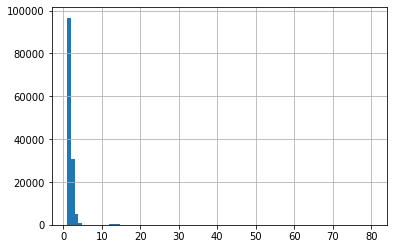

In [8]:
genre_counts = unique_songs.genre.count()
genre_counts.hist(bins=80)
plt.show()

We can see that the vast majority of tracks have a single genre classification, but a subset has from two to 80 tracks.

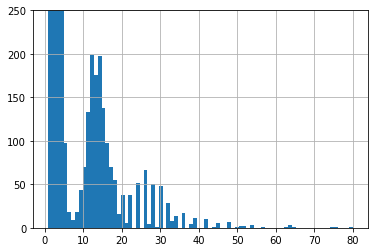

In [9]:
genre_counts.hist(bins=80)
plt.ylim([0,250])
plt.show()

If we focus on the area close below 250 tracks, we can see that there is a multimodal distribution of number of track tags. Some tracks have as many as 80 genres tagged, and there is a strong continuous peak between 10-20 tracks.

In [10]:
print((genre_counts > 1).sum())
print((genre_counts > 2).sum())

38004
7224


Roughly 38000 tracks have multiple genre tags, though the vast majority of these have two genre classifications. If we focus on a subset of genres, we may be able to use some of these tracks by eliminating genre tags we are not focusing on.

In [11]:
genres.genre.value_counts()

Rock                      56226
Pop                       46089
Jazz                      18897
Electronic                17622
Folk, World, & Country    17236
Hip Hop                   14935
Funk / Soul               12355
Latin                      7190
Blues                      5270
Stage & Screen             3512
Reggae                     2853
Classical                   889
genre                       850
Non-Music                   367
Children's                  349
Brass & Military             26
genres                        8
Ce genre de Mec               5
Ce genre                      2
Rapgenre                      2
 Buy This Song                1
Le genre féminin              1
transgenres                   1
Ce genre Lyrics               1
Name: genre, dtype: int64

We can see that there are a subset of genres that are much better represented than others. We will likely have to narrow our group of genres down to two to three genres to focus on. For this first filter, we will subset the data to genres with more than 10,000 tagged songs.

In [12]:
genres_many = ['Rock', 'Pop', 
               'Jazz', 'Electronic', 
               'Folk, World, & Country', 'Hip Hop', 
               'Funk / Soul']

genres_filtered = genres[genres.genre.isin(genres_many)]

In [13]:
genre_vals = genres_filtered.groupby(['artist','song_title']).genre.apply(list)


We can now look at which genres co-occur with other genres the most.

In [14]:
genres_reduced = genres_filtered[['artist','song_title','genre']]
genres_pivot = genres_reduced.pivot_table('artist', 'song_title', 'genre', aggfunc=len, fill_value=0)
genres_pivot[genres_pivot > 0] = 1

In [15]:
multi_genre = genres_pivot.apply(sum, axis=1) > 1
genres_pivot = genres_pivot[multi_genre]

In [16]:
u = genres_pivot
v = u.T.dot(u)
v.values[[np.arange(v.shape[0])]*2] = 0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
v.sum()

genre
Electronic                12801
Folk, World, & Country     9171
Funk / Soul                9544
Hip Hop                    6477
Jazz                       7522
Pop                       25329
Rock                      23178
dtype: int64

In [18]:
v

genre,Electronic,"Folk, World, & Country",Funk / Soul,Hip Hop,Jazz,Pop,Rock
genre,,,,,,,
Electronic,0,784,1473,1651,598,4093,4202
"Folk, World, & Country",784,0,854,452,822,3027,3232
Funk / Soul,1473,854,0,1096,1156,2719,2246
Hip Hop,1651,452,1096,0,287,1532,1459
Jazz,598,822,1156,287,0,3289,1370
Pop,4093,3027,2719,1532,3289,0,10669
Rock,4202,3232,2246,1459,1370,10669,0


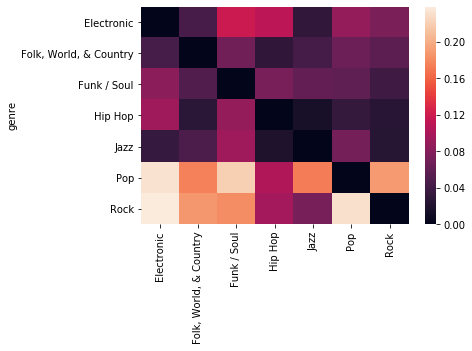

In [19]:
sns.heatmap(v / genres_reduced.genre.value_counts())
plt.show()

This heatmap is normalized by column for the total count of each genre. So for example, the Rock column represents the proportion of all Rock songs that overlap with each other potential genre. The Rock row represents the proportion of every other label that is also classified as Rock.

From this we can see that Rock and Pop are the most promiscuous genres, and that this is especially true between these two groups. Looking crosswise, we can see that virtually every other genre has between 15%-20% of its multilabeled instances labeled as a combination with Rock, and the same is generally true with Pop. Only Jazz and Hip Hop somewhat buck this trend.

This may serve as a reason to exclude one or both of the Pop and Rock genres from classification tasks, as they seem to have less information content than other genre classifications. We will also limit to songs that only have one genre classification.

In [20]:
final_genres = ['Rock', 'Jazz', 'Electronic', 
               'Folk, World, & Country', 'Hip Hop', 
               'Funk / Soul']

genres_final = genres[genres.genre.isin(final_genres)]
is_single = genres_final.groupby(['artist','song_title']).count()
is_single = is_single[is_single.genre > 1]
is_single = is_single.reset_index()

# Create complex key
is_single['complex'] = is_single.artist.astype(str) + is_single.song_title.astype(str)
genres_final['complex'] = genres_final.artist.astype(str) + genres_final.song_title.astype(str)

genres_final = genres_final[~genres_final.complex.isin(is_single.complex)]
genres_final = genres_final.drop('complex', axis=1)
genres_final.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,artist,song_title,year,genre,lyrics
28750,Doro Pesch,Long Way Home,1999.0,Rock,Father\r\nGive me just a sign\r\nThat I'll sur...
28759,Marius Müller-Westernhagen,Fertig,2011.0,Rock,"""Fertig""\nBy Marius Müller Westernhagen\nDo ka..."
28761,The Animals,Don't Bring Me Down,1966.0,Rock,When you complain and criticize \r\nI feel I'...
28768,E-40,V-Town,1992.0,Hip Hop,"(Hi, the state and what city, please?)\r\nVall..."
28769,Oingo Boingo,Pain,1987.0,Rock,Welcome to my little world...completely self-c...


For our purposes here, we will exclude the Pop genre from classification in hopes that it will decrease cross-genre classification errors. We also limit to tracks with only one genre tag represented.

# Song Language

In [21]:
from langdetect import detect

result = []
for lyr in tqdm(genres_final.lyrics):
    if len(lyr) >= 50:
        try:
            result.append(detect(lyr[:50]))
        except:
            result.append(detect(lyr[50:]))
    else:
        result.append(detect(lyr))

genres_en = genres_final[np.array(result) == 'en']
genres_en.head()

,artist,song_title,year,genre,lyrics
28750,Doro Pesch,Long Way Home,1999.0,Rock,Father\r\nGive me just a sign\r\nThat I'll sur...
28761,The Animals,Don't Bring Me Down,1966.0,Rock,When you complain and criticize \r\nI feel I'...
28768,E-40,V-Town,1992.0,Hip Hop,"(Hi, the state and what city, please?)\r\nVall..."
28769,Oingo Boingo,Pain,1987.0,Rock,Welcome to my little world...completely self-c...
28772,Dinah Washington,I Get a Kick Out of You,1990.0,Jazz,"My story is much too sad to be told,\nBut prac..."


We can detect English language lyrics and limit our data set to that subset.

# Language Data Preparation

## Deprecated: Now doing all of this in sklearn in next section

Need to create a new class to perform lemmatization as part of sklearn implmentation. [see link](https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer)

In [22]:
# import nltk

# # Creating tokens
# lemma_lyr = genres_en.lyrics
# lemma_lyr = [l.lower() for l in lemma_lyr]
# lemma_lyr = [nltk.word_tokenize(l) for l in lemma_lyr]

We first tokenize our lyrics into a nested list of words. We lowercase all alphanumeric characters as well so that they are more easily grouped.

In [23]:
# from nltk.corpus import stopwords
# en_stops = set(stopwords.words('english'))

# lemma_lyr2 = []
# for l in tqdm(lemma_lyr):
#     lem = [w for w in l if w not in en_stops and w.isalnum()]
#     lemma_lyr2.append(lem)

We then filter out English stopwords, which occur very regularly and may be uninformative for classification. We also filter out punctuation.

In [24]:
# # Stem words
# from nltk.stem.porter import PorterStemmer

# porter = PorterStemmer()
# stemmed = [[porter.stem(t) for t in song] for song in tqdm(lemma_lyr2)]

# NLP Model Feature Conversion

In [25]:
genres_en_sorted = genres_en.copy()
genres_en_sorted['song_title'] = genres_en_sorted['song_title'].str.replace('[^\w\s]','')
genres_en_sorted = genres_en_sorted.sort_values('song_title')
genres_en_sorted

,artist,song_title,year,genre,lyrics
150322,Cutting Crew,Between A Rock And A Hard Place,1994.0,Rock,Between a rock\nBetween a rock and a hard plac...
108135,Juelz Santana,Girlz,2004.0,Hip Hop,"Rich girl, and you've come to far\n'cause you ..."
49920,Young Gunz,Girlz,2004.0,Hip Hop,"Rich girl, and you've come to far\n'cause you ..."
145050,Andy Williams,and Roses and Roses,2002.0,Jazz,Every day I sent another present\r\nJust to le...
185287,N.W.A,tha Police,1988.0,Hip Hop,"""Right about now, N.W.A. court is in full effe..."
...,...,...,...,...,...
159305,Tool,Ænema,1996.0,Rock,Some say the end is near\nSome say we'll see A...
60492,La Fouine,Ça Fait Mal,2010.0,Hip Hop,"Okay, this is the remix baby (remix)\nOh oh zz..."
55870,Camille,Çats and Dogs,2013.0,Electronic,Cats and dogs are not our friends\nThey just p...
33418,Nightwish,Élan,2015.0,Rock,Leave the sleep and let the springtime talk\nI...


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english',
                            strip_accents='ascii',
                            max_df=0.95, # ignore terms that appear in >98% of documents
                            min_df=0.001) # ignore terms that appear in <01% of documents
X = vectorizer.fit_transform(genres_en_sorted.lyrics)

In [27]:
features = pd.DataFrame({'feature': vectorizer.get_feature_names(),
                         'count':X.toarray().sum(axis=0)})
features.sort_values('count', ascending=False)[:10]

,feature,count
2938,love,150128
1419,don,125984
2704,know,114992
2841,like,113212
2633,just,104475
2111,got,94470
2885,ll,91931
3365,oh,90905
242,baby,71096
5128,time,65366


# Duplicate Detection

Because lyrics.com is rife with covers and collaborations, we need to find and eliminate duplicate records in our lyrics database. The following class will do so (though not exhaustively). It iterates through subsets of the data finding duplicate song records defined by cosine similarity between the word vectors. It will retain the earliest version of the song amongst the detected set of duplicates. 

The reason for splitting the dataset into subchunks is the amount of memory required by the similarity matrix. For the full set of 85k rows, the similarity matrix requires over 50 GB of RAM. For this reason we focus on subsets. If a song has a duplicate in another chunk, this method will not find it, though we can run it iteratively in order to find additional matches. In order to maximize the number of matches found, we sort by song title, increasing the chance that similar lyrics will be in the same chunk.

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

class Deduplicator:
    def __init__(self, df, matrix, threshold=0.8, increment=20000):
        self.df = df
        self.matrix = matrix
        self.threshold = threshold
        self.increment = increment
        self.years = df.year.values
        self.tiebreaker = np.array([])
        self.index = np.ones(matrix.shape[0], dtype=bool)
    
    def make_sim_matrix(self, mat):
        '''Make cosine similarity matrix from sparse matrix'''
        similarity = cosine_similarity(mat.toarray())
        np.fill_diagonal(similarity, 0)
        self.similarity = similarity
        
    def check_years(self, ind1, ind2):
        '''Compares two years and returns the indices that should be zeroed out
           which corresponds with the later of the two years'''
        y1, y2 = self.years[ind1], self.years[ind2]
        if y1 == y2:
            if ind1 in self.tiebreaker and ind2 not in self.tiebreaker:
                return ind2
            elif ind2 in self.tiebreaker and ind1 not in self.tiebreaker:
                return ind1
            else:
                self.tiebreaker = np.append(self.tiebreaker, ind1)
                return ind2
        if y1 < y2:
            return ind2
        else:
            return ind1
        
    def deduplicate(self):
        '''iterate through chunks of the data creating similarity matrices
           and eliminating newer versions of old songs'''
        i = 0 # global matrix index
        dup = []
        mat_max = self.matrix.shape[0]
        progress = tqdm(total=mat_max)
        update_amt = self.increment
        while i < mat_max:
            if i + self.increment < mat_max:
                self.make_sim_matrix(self.matrix[i: i + self.increment])
            else:
                self.make_sim_matrix(self.matrix[i: mat_max])
                update_amt = mat_max % i
            dup = np.where(self.similarity > self.threshold)
            for j in range(len(dup[0])):
                ind = self.check_years(dup[0][j], dup[1][j]) + i
                self.index[ind] = False
            i += self.increment
            progress.update(update_amt)


In [29]:
d = Deduplicator(df=genres_en_sorted,
                 matrix=X,
                 increment=20000,
                threshold=0.7)

d.deduplicate()

In [30]:
songs_no_dupes = genres_en_sorted[d.index]
songs_no_dupes.shape

(47001, 5)

This decreases our training set from 84,000 records to 47,000 records. This sample indicates that almost 45% of the dataset is comprised of duplicate records. This deduplication approach may also catch some edge cases, like songs with placeholder text, songs with very simple lyrics ("lalala"), and popular songs (which are more likely to be those tagged with a genre).

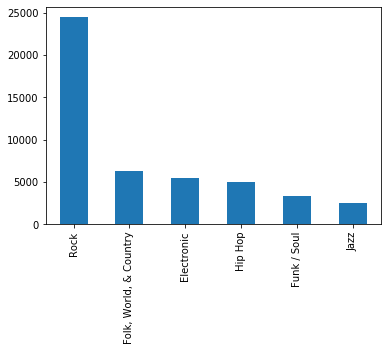

In [31]:
songs_no_dupes.genre.value_counts().plot.bar()

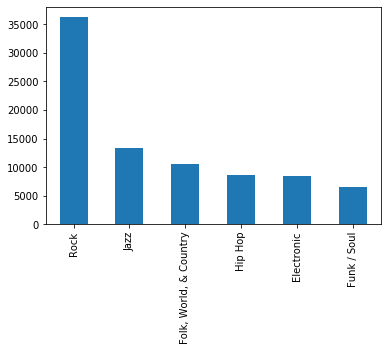

In [32]:
genres_en_sorted.genre.value_counts().plot.bar()

When we look at the before and after plots, we can see that Jazz and Folk were hit the hardest by the deduplication process, while the mix of Rock, Folk, and Electronic remained fairly consistent. 

# TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents='ascii',
                       ngram_range=(1,3),
                       max_df=0.98,
                       min_df=0.001)

X_tfidf = tfidf.fit_transform(songs_no_dupes.lyrics)

In [52]:
test = X_tfidf.toarray()
test2 = test > 0

In [68]:
output = np.zeros(test2.shape)
for i in tqdm(range(test.shape[0])):
    for j in range(test.shape[1]):
        output[i,j] = np.bitwise_xor(test2[i], test2[j]).sum()

KeyboardInterrupt: 

In [67]:
import multiprocessing

pool = multiprocessing.Pool(4)


# Bit array duplicate detection

In [38]:
X.toarray().shape

(83716, 5723)

# Save output files

In [35]:
save_path = '../data/processed/'
import pickle
pickle.dump(genres, open(save_path + 'lyric_genres.pickle', 'wb'))
pickle.dump(data, open(save_path + 'lyric_full.pickle', 'wb'))

In [36]:
pickle.dump(songs_no_dupes, open(save_path + 'songs_no_dupes.pickle', 'wb'))